In [19]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Mr3'
#testing random feature drops
#TREND

data = data.drop(columns='FT')
#data = data.drop(columns='vel5')
#data = data.drop(columns='vel10')
#data = data.drop(columns='vel15')
#data = data.drop(columns='vel30')
#data = data.drop(columns='vel60')
#data = data.drop(columns='acc5')
#data = data.drop(columns='acc10')
#data = data.drop(columns='acc15')
#data = data.drop(columns='acc30')
#data = data.drop(columns='acc60')
#data = data.drop(columns='stoch12')
#data = data.drop(columns='stochDiff6012')
#data = data.drop(columns='RSIhl_diff')
#data = data.drop(columns='RSIhl_diffROC')
#data = data.drop(columns='YM_diff')
#data = data.drop(columns='NQ_diff')

#PARTICIPATION


#data = data.drop(columns='vol')
#data = data.drop(columns='vol10')
#data = data.drop(columns='vol15')
#data = data.drop(columns='vol30')
#data = data.drop(columns='vol60')
#data = data.drop(columns='volD10')
#data = data.drop(columns='volD15')
#data = data.drop(columns='volD30')
#data = data.drop(columns='volD60')
#data = data.drop(columns='volNQdiff')
#data = data.drop(columns='volYMdiff')
#data = data.drop(columns='vpm5')
#data = data.drop(columns='vpm10')
#data = data.drop(columns='vpm15')
#data = data.drop(columns='ToD')
#data = data.drop(columns='DoW')

#CALENDAR


#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')


data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')



#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

#print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
#unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
#print(dict(zip(unique,counts)))

#filtering before splitting could be useful if ABSOLUTELY mostly comprised of 'in'
#MARKET HOURS!
#data = data.drop(data[data['ToD'] > 950].index)
#data = data.drop(data[data['ToD'] < 560].index)
#OTHER MODIFICATIONS
#data = data.drop(data[data['feature'] condition].index)
data = data.drop(data[data['MO'] < 1].index)



#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


#Encoding data



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.reshape(X_train, (int(X_train.shape[0]/7), 7, X_train.shape[1]))

# one-hot encode ? 

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#y_test = to_categorical(y_test, num_classes=4)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

def custom_loss(y_true, y_pred):
    # Calculate the absolute error
    error = tf.abs(y_true - y_pred)
    
    # Define conditions for different error ranges
    is_large_error = tf.greater(error, 1.0)       # Error > 1.0
    is_small_error = tf.less_equal(error, 0.25)   # Error <= 0.25
    
    # Apply penalties for large errors: penalize more for errors > 1.0
    large_error_penalty = tf.where(is_large_error, error ** 2, 0.0)
    
    # Apply reward for small errors: reward by reducing loss for errors <= 0.25
    small_error_reward = tf.where(is_small_error, -0.1 * error, 0.0)  # Reward by reducing the loss
    
    # Neutral loss for errors in between (0.25 < error <= 1.0)
    neutral_loss = tf.where(~is_large_error & ~is_small_error, error, 0.0)
    
    # Combine penalties and rewards
    total_loss = large_error_penalty + small_error_reward + neutral_loss
    
    # Return the average loss over the batch
    return tf.reduce_mean(total_loss)



#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.1,
    decay_steps=186,
    decay_rate=0.9,
    staircase=True)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.01)
opt3 = SGD(learning_rate=lr_schedule)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)

def build_LSTM_model():
    time_steps=5
    n_features=len(Xfeatures)
    output_unit=1
    lstm_activation='tanh'

    model = tf.keras.Sequential([
        #tf.keras.layers.Input(shape=(35,)),
        tf.keras.layers.LSTM(64, activation=lstm_activation),#, input_shape=(time_steps, n_features)),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dense(2048),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.20),
        #tf.keras.layers.Dense(1024),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    #AUC=tf.keras.metrics.AUC(curve='PR')
    met = ['precision','recall','accuracy']
    model.compile(optimizer=opt3,
                  loss='binary_crossentropy'
                  ,metrics=['R2Score','mse'])
    return model



def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('dmReg_rec1.keras')
    loaded_model.compile(optimizer=opt3,
                         loss='mae'
                         , metrics=['R2Score','mse'])
    return loaded_model


#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 5

early_stopping = EarlyStopping(monitor='val_recall', patience=250, mode='max', restore_best_weights=True)

model = build_LSTM_model()
loaded_model = load_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    )#batch_size=849)#callbacks=[metric_callback])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# AUC
plt.plot(epochs, history.history['AUC'], 'y', label='Training AUC')
plt.plot(epochs, history.history['val_AUC'], 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# PRECISION
plt.plot(epochs, history.history['precision'], 'y', label='Training Precision')
plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# RECALL
plt.plot(epochs, history.history['recall'], 'y', label='Training Recall')
plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# TPR


TPR = history.history['TruePositives']/(history.history['TruePositives']+history.history['TrueNegatives'])
val_TPR = history.history['val_TruePositives']/(history.history['val_TruePositives']+history.history['val_TrueNegatives'])
plt.plot(epochs, TPR, 'y', label='Training TPR')
plt.plot(epochs, val_TPR, 'r', label='Validation TPR')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('TP Rate')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

'''

#predicting the test set results
y_pred = model.predict(X_test) 
#y_pred = y_pred > 0.5 # Predictions to class indices
'''
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Classification')
plt.show()
'''

plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(0,5)
plt.ylim(0,5)
plt.ylabel('y_test')
plt.show()

# Save the model
#model.save('epoch15k.keras')
# Load the model
#loaded_model = tf.keras.models.load_model('my_model.keras')

TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'YM_diff', 'NQ_diff', 'vol', 'vol10', 'vol15', 'vol30',
       'vol60', 'volD10', 'volD15', 'volD30', 'volD60', 'volNQdiff',
       'volYMdiff', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD', 'DoW',
       'MO'],
      dtype='object')
TESTING FOR: 
Mr3


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 849
'y' sizes: 5943


In [40]:
# Save the model
loaded_model.save('dmReg_rec1.keras')

In [25]:
print(y_pred,y_test,sep='\t')

print(X_test[0])
print(X_test[1])
print(X_test[2])

[[0.70300716]
 [0.59242254]
 [0.986246  ]
 ...
 [1.1672951 ]
 [1.7254387 ]
 [0.7041494 ]]	[0.4084 0.2077 2.0762 ... 2.2549 4.0791 0.1497]
[-0.30909206 -0.00482098  0.06859997 -0.19255195 -0.18555097 -0.42193071
 -0.05724611  0.28148903 -0.08353789 -0.25489117 -0.40555301 -0.10895216
  0.55159307  0.13936676  0.5793675  -0.36031629 -0.4030192  -0.39647853
 -0.33207338 -0.39678441 -0.19869235 -0.15392743 -0.34861774 -0.17834132
 -0.37716372 -0.01312875  0.45894897 -0.30360586 -0.05855382 -0.06432187
 -0.06458413 -0.06693589 -0.09441513 -0.00260275  0.        ]
[ 2.3030512   1.89345973  2.50232183  1.4656017  -0.05650354  1.38807449
  0.46435495  2.00877617  2.12087228  0.89781393  0.41108756  1.59327848
 -1.29548405 -1.8300144   0.16864088  0.35564027  1.07815112  0.8990935
  0.78458171  1.15414436  1.40391868  0.56137875  0.61949629  0.04151975
 -0.13240182  1.05253998  0.70461834  1.02057559  1.08613482  1.3745672
  0.61959318 -0.06693589 -0.13589888  1.40359361  0.        ]
[-1.274654

In [32]:
model.summary()
lm = load_model('dmRec_rec1.keras')
lm.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ activation_28 (Activation)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,087,489 (4.15 MB)

 Trainable params: 1,087,489 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: dmRec_rec1.keras (of type <class 'str'>)

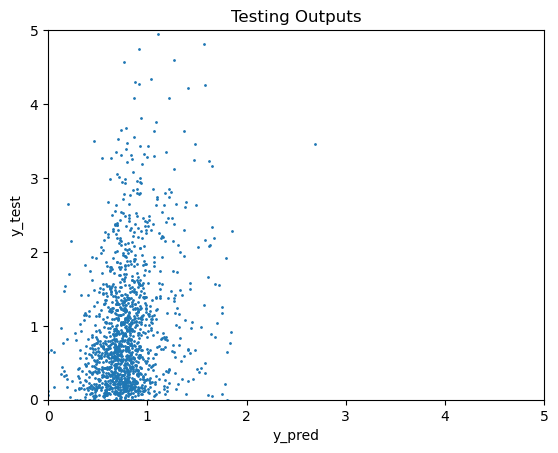

In [38]:
plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(0,5)
plt.ylim(0,5)
plt.ylabel('y_test')
plt.show()

In [44]:
# Import necessary libraries
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
import numpy as np

# Load your pre-trained model
model = load_model('dmReg_rec1.keras')

# Assuming you have your data and labels as numpy arrays (X, y)
# X: Features, y: Labels (binary classification: 0 or 1)

# Set the number of folds (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
mse_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    # Optionally, reset the model's weights before each fold
    # model.load_weights('path_to_weights') # If you want to use the same weights every time
    
    # Re-train the model on the fold's training data
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Predict and calculate mean squared error on the test data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate average accuracy over all folds
mean_mse = np.mean(mse_scores)
print(f'Mean MSE: {mean_mse}')

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: -5940.4028 - loss: 8.5924 - mse: 6786.3228  
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -5.7757 - loss: 1.1279 - mse: 7.4655
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -5.6082 - loss: 1.1206 - mse: 7.4288
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -3.0662 - loss: 1.0886 - mse: 4.7600
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -1.8574 - loss: 1.0890 - mse: 3.6314
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -1.5030 - loss: 1.0595 - mse: 3.0816
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -1.1574 - loss: 1.0336 - mse: 2.4377
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -0.8773 - loss: 1.0381 - mse: 2.3616
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -1.0153 - loss: 1.0374 - mse: 2.4283
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: -1.5800 - loss: 1.0607 - mse